# Cancer Patient Risk and Survival Analysis

In [1]:
!pip install lifelines
!pip install --upgrade lifelines pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index


C:\Users\abhij\anaconda3\envs\flask\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("global_cancer_patients_2015_2024.csv")
df.head()


,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


In [3]:
# Drop non-informative column
df.drop("Patient_ID", axis=1, inplace=True)

# Encode categorical variables
label_encoders = {}
for col in ["Gender", "Country_Region", "Cancer_Type", "Cancer_Stage"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [4]:
# Create binary target
df["Severity_Risk"] = (df["Target_Severity_Score"] > df["Target_Severity_Score"].median()).astype(int)

# Define features and target
X = df.drop(["Target_Severity_Score", "Survival_Years", "Severity_Risk"], axis=1)
y = df["Severity_Risk"]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_log))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5067
           1       1.00      1.00      1.00      4933

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC AUC Score: 0.999394531282037


Random Forest Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      5067
           1       0.96      0.95      0.95      4933

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

ROC AUC Score: 0.9541488869741451


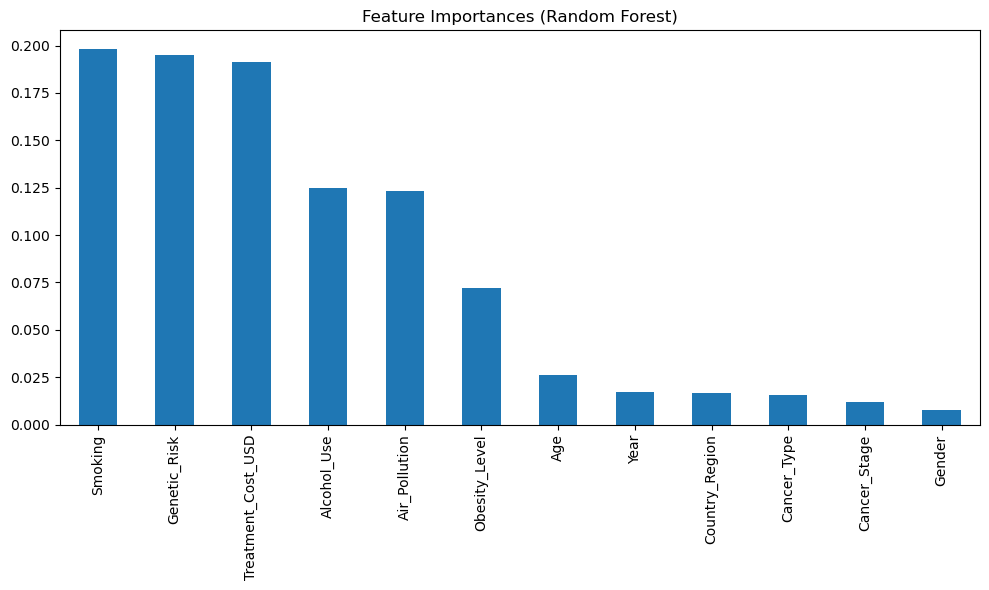

In [7]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))

# Feature Importance Plot
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6), title="Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [8]:
survival_df = df[["Survival_Years", "Severity_Risk"] + list(X.columns)]

cox_model = CoxPHFitter()
cox_model.fit(survival_df, duration_col='Survival_Years', event_col='Severity_Risk')
cox_model.print_summary()

c_index = concordance_index(
    survival_df["Survival_Years"],
    -cox_model.predict_partial_hazard(survival_df),
    survival_df["Severity_Risk"]
)
print("Concordance Index (Cox Regression):", c_index)


<lifelines.CoxPHFitter: fitted with 50000 total observations, 25060 right-censored observations>
             duration col = 'Survival_Years'
                event col = 'Severity_Risk'
      baseline estimation = breslow
   number of observations = 50000
number of events observed = 24940
   partial log-likelihood = -236981.73
         time fit was run = 2025-05-15 22:22:51 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
Age                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Gender              0.01      1.01      0.01           -0.01            0.02                0.99                1.02
Country_Region     -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
Year                0.00      1.00      0.00           -0.00            0.01                1.00                1.01
Genetic_Risk        0.14      1.15      0.00            0.14            0.15                1.15                1.16
Air_Pollution       0.10      1.11      0.00            0.10            0.10                1.10                1.11
Alcohol_Use         0.11      1.11      0.00            0.10            0.11                1.11                1.12
Smoking             0.14      1.15      0.00            0.14            0.15                1.15                1.16
Obesity_Level       0.06      1.06      0.00            0.06            0.06                1.06                1.07
Cancer_Type         0.00      1.00      0.00           -0.00            0.01                1.00                1.01
Cancer_Stage        0.01      1.01      0.00           -0.00            0.02                1.00                1.02
Treatment_Cost_USD -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                    cmp to      z      p  -log2(p)
covariate                                         
Age                   0.00  -0.44   0.66      0.60
Gender                0.00   1.08   0.28      1.84
Country_Region        0.00  -0.85   0.40      1.33
Year                  0.00   0.39   0.70      0.52
Genetic_Risk          0.00  60.84 <0.005       inf
Air_Pollution         0.00  44.61 <0.005       inf
Alcohol_Use           0.00  47.06 <0.005       inf
Smoking               0.00  61.49 <0.005       inf
Obesity_Level         0.00  27.30 <0.005    542.73
Cancer_Type           0.00   0.39   0.70      0.52
Cancer_Stage          0.00   1.78   0.08      3.73
Treatment_Cost_USD    0.00 -58.29 <0.005       inf
---
Concordance = 0.75
Partial AIC = 473987.47
log-likelihood ratio test = 16664.59 on 12 df
-log2(p) of ll-ratio test = inf

Concordance Index (Cox Regression): 0.7510105799287801


In [9]:
df.to_csv("Processed_Cancer_Data.csv", index=False)
print("\nAnalysis Complete. Outputs saved.")



Analysis Complete. Outputs saved.
